In [43]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import xgboost
from sklearn.metrics import accuracy_score

# Load and Pre-Process the Data

In [44]:
df = pd.read_csv('../data/founder_V0.3_founder.csv')

In [45]:
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['Full_Name', 'Primary_Job_Title', 'Bio', 'Gender',
       'Number_of_News_Articles', 'Number_of_Founded_Organizations',
       'Number_of_Portfolio_Companies', 'Number_of_Investments_x',
       'Number_of_Partner_Investments', 'Number_of_Lead_Investments_x',
       'Number_of_Exits_x', 'Number_of_Events_x', 'Categories',
       'Headquarters_Location_', 'Operating_Status', 'Founded_Date',
       'Closed_Date', 'Company_Type', 'Number_of_Founders', 'Success',
       'Founder'],
      dtype='object')

In [46]:
df.shape

(18361, 21)

In [47]:
filtered_df = df.drop(['Full_Name', 'Primary_Job_Title', 'Bio', 'Number_of_Portfolio_Companies', 'Number_of_Investments_x','Number_of_Partner_Investments', 'Number_of_Lead_Investments_x', 'Number_of_Events_x', 'Founded_Date', 'Closed_Date', 'Company_Type', 'Founder'], axis=1)


In [48]:
print(filtered_df.shape)

(18361, 9)


In [49]:
categories_dummy = df['Categories']
categories_dummy = categories_dummy.str.split(',', expand=True)
categories_dummy = categories_dummy[0]
categories_dummy = pd.get_dummies(categories_dummy)
print(categories_dummy.shape)

(18361, 584)


In [50]:
filtered_df = pd.concat([filtered_df, categories_dummy], axis=1)
print(filtered_df.shape)

(18361, 593)


In [51]:
hq_dummy = df['Headquarters_Location_']
hq_dummy = pd.get_dummies(hq_dummy)
print(hq_dummy.shape)

(18361, 142)


In [52]:
filtered_df = pd.concat([filtered_df, hq_dummy], axis=1)
print(filtered_df.shape)

(18361, 735)


In [53]:
filtered_df = filtered_df.drop(['Headquarters_Location_', 'Categories'], axis=1)
print(filtered_df.shape)

(18361, 733)


# Inspecting the Dataset

In [64]:
y = filtered_df['Success'].values
X = filtered_df.drop('Success', axis=1)
X = filtered_df.drop('0', axis=1)
print("Shape of X: " + str(X.values.shape))
print("Shape of y: " + str(y.shape))


Shape of X: (18361, 731)
Shape of y: (18361,)


# Train & Test Split

In [65]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 1234) 

### XGBoost

In [76]:
# instantiate
xgb = xgboost.XGBRegressor()

# fit the model to training data
xgb.fit(x_train, y_train)

# y prediction
y_pred_xgb = xgb.predict(x_test)

# xgb_score_TRAIN = accuracy_score(y_train, y_pred_xgb)
xgb_score_TEST = accuracy_score(y_test, y_pred_xgb.round())

# print("XGB training data accuracy: " + str(xgb_score_TRAIN*100))
print("XGB testing data accuracy: " + str(xgb_score_TEST))

XGB testing data accuracy: 1.0


In [57]:
X = pd.DataFrame(X)
rand_forest_feature_importance = pd.DataFrame({
    'feature' : X.columns,
    'importance': rand_forest.feature_importances_
}).sort_values(by = 'importance', ascending=False)

rand_forest_feature_importance[:10]

,feature,importance
1,Number of News Articles,0.171992
5,Number of Founders,0.083332
2,Number of Founded Organizations,0.039341
607,California,0.019167
675,New York,0.013552
0,Gender,0.012226
612,China,0.010248
3,Number of Exits_x,0.009493
507,Software,0.009316
638,India,0.008903


# KNN

In [58]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors= int(np.sqrt(18361)))
knn.fit(x_train, y_train)
y_pred_KNN = knn.predict(x_test)

knn_score_train = round(knn.score(x_train, y_train)*100, 2)
knn_score_test =  round(knn.score(x_test, y_test)*100, 2)

print("KNN Train Score: " + str(knn_score_train))
print("KNN Test Score: " + str(knn_score_test))

KNN Train Score: 68.45
KNN Test Score: 66.78


In [59]:
avg_precision_knn = average_precision_score(y_test, y_pred_KNN)
print("Avg Precision Score: {}".format(str(avg_precision_knn)))

Avg Precision Score: 0.4900233791769417


Text(0.5, 0, 'Recall')

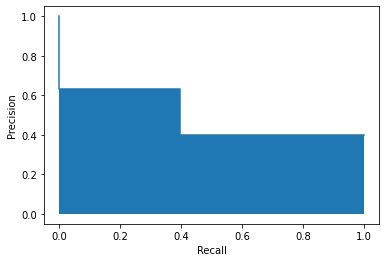

In [60]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_KNN)
plt.step(recall, precision, where="post")
plt.fill_between(recall, precision, step="post")
plt.ylabel("Precision")
plt.xlabel("Recall")